In [109]:
!pip install tensorflow

In [111]:
!pip install mediapipe

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import os
import gc
import re
import shutil
import time
import json
import tensorflow as tf
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output, FileLink
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Bidirectional, LSTM, Dense, Masking
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

## Data Preprocessing

In [7]:
asl_df = pd.read_csv(r"D:\cDrive_Files\GRADUATION_PROJECT\ASL\30videodataset (1).csv")
display(asl_df)

,Video file,Gloss
0,14154575310664197-NICE.mp4,NICE
1,18199086230023087-NICE.mp4,NICE
2,3597949009905055-NICE.mp4,NICE
3,8565239257906878-NICE.mp4,NICE
4,2575780253377702-NICE.mp4,NICE
...,...,...
354,22369668985632774-YOUR.mp4,YOUR
355,32521170014807677-YOUR.mp4,YOUR
356,8184724937356351-YOUR.mp4,YOUR
357,217732808571379-YOUR.mp4,YOUR


In [8]:
asl_df.shape

(359, 2)

In [9]:
selected_glosses = np.array(asl_df["Gloss"].unique())
selected_glosses

array(['NICE', 'THANKYOU', 'MEET', 'FINE1', 'HOW1', 'WHAT1', 'COOL4',
       'NAME', 'HELLO', 'YOU', 'ME', 'YOUR'], dtype=object)

In [10]:
def clean_gloss(gloss):
    return re.sub(r'\d+', '', gloss).lower().strip()
asl_df["Gloss"] = asl_df["Gloss"].apply(clean_gloss)

In [11]:
asl_df

,Video file,Gloss
0,14154575310664197-NICE.mp4,nice
1,18199086230023087-NICE.mp4,nice
2,3597949009905055-NICE.mp4,nice
3,8565239257906878-NICE.mp4,nice
4,2575780253377702-NICE.mp4,nice
...,...,...
354,22369668985632774-YOUR.mp4,your
355,32521170014807677-YOUR.mp4,your
356,8184724937356351-YOUR.mp4,your
357,217732808571379-YOUR.mp4,your


In [12]:
selected_glosses = np.array(asl_df["Gloss"].unique())
selected_glosses

array(['nice', 'thankyou', 'meet', 'fine', 'how', 'what', 'cool', 'name',
       'hello', 'you', 'me', 'your'], dtype=object)

#### Augmentation

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

# Define directories
video_base_dir = r"D:\cDrive_Files\GRADUATION_PROJECT\ASL\ASL_Gloss_30Videos\ASL_Gloss_30Videos"
augmented_videos_dir = r"D:\cDrive_Files\GRADUATION_PROJECT\ASL\augmented_data_3"
os.makedirs(augmented_videos_dir, exist_ok=True)

# Video Augmentation Functions
def rotate_video(frames):
    angle = random.uniform(-5, 5)
    h, w = frames[0].shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return [cv2.warpAffine(frame, matrix, (w, h)) for frame in frames]

def speed_video(frames):
    factor = random.uniform(0.85, 1.15)
    indices = np.linspace(0, len(frames) - 1, int(len(frames) * factor), dtype=int)
    return [frames[i] for i in indices]

def flip_frames(frames): 
    return [cv2.flip(frame, 1) for frame in frames]

def brighten_video(frames):
    factor = random.uniform(1.1, 1.4)
    beta = random.randint(20, 50)
    return [cv2.convertScaleAbs(frame, alpha=factor, beta=beta) for frame in frames]

def adjust_contrast_video(frames, is_high=True):
    contrast = random.randint(15, 40)
    alpha = 1 + contrast / 100 if is_high else 1 - contrast / 100
    return [cv2.convertScaleAbs(frame, alpha=alpha, beta=0) for frame in frames]

def blur_video(frames):
    sigma = random.uniform(0.8, 1.5)
    return [np.clip(gaussian_filter(frame, sigma=sigma), 0, 255).astype(np.uint8) for frame in frames]

def crop_video(frames):
    margin = random.randint(20, 40)
    h, w = frames[0].shape[:2]
    return [frame[margin:h - margin, margin:w - margin] for frame in frames]

def save_video(frames, output_path, fps=25):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    height, width, _ = frames[0].shape
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    for frame in frames:
        out.write(frame)
    out.release()

def augment_video(video_path, output_dir, augmentations):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()

    if not frames:
        return

    original_output_path = os.path.join(output_dir, f"{os.path.basename(video_path).split('.')[0]}_original.mp4")
    save_video(frames, original_output_path)

    for augmentation in augmentations:
        augmented_frames = None
        if augmentation == "rotate":
            augmented_frames = rotate_video(frames)
        elif augmentation == "speed":
            augmented_frames = speed_video(frames)
        elif augmentation == "flip":
            augmented_frames = flip_frames(frames)
        elif augmentation == "brighten":
            augmented_frames = brighten_video(frames)
        elif augmentation == "high_contrast":
            augmented_frames = adjust_contrast_video(frames, is_high=True)
        elif augmentation == "low_contrast":
            augmented_frames = adjust_contrast_video(frames, is_high=False)
        elif augmentation == "blur":
            augmented_frames = blur_video(frames)
        elif augmentation == "crop":
            augmented_frames = crop_video(frames)

        if augmented_frames:
            output_path = os.path.join(output_dir, f"{os.path.basename(video_path).split('.')[0]}_aug_{augmentation}.mp4")
            save_video(augmented_frames, output_path)

# Process Videos
for _, row in tqdm(asl_df.iterrows(), total=asl_df.shape[0]):
    video_file = row["Video file"]
    gloss = row["Gloss"]
    video_path = os.path.join(video_base_dir, gloss, video_file)
    
    if os.path.exists(video_path):
        gloss_dir = os.path.join(augmented_videos_dir, gloss)
        os.makedirs(gloss_dir, exist_ok=True)
        augment_video(
            video_path,
            gloss_dir,
            augmentations=["rotate", "speed", "flip", "brighten", "high_contrast", "low_contrast", "blur", "crop"]
        )

print(f"Augmented videos and originals saved to {augmented_videos_dir}")

In [51]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

def image_process(image, model):
    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Set the image to read-only mode
    image.flags.writeable = False
    # Process the image using the model
    results = model.process(image)
    # Set the image back to writeable mode
    image.flags.writeable = True
    # Convert the image back from RGB to BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def extract_keypoints(results):
    """Extract keypoints from MediaPipe results."""
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([left_hand, right_hand])

#### Keypoints extraction

In [149]:
import mediapipe as mp
import cv2
import numpy as np
import os

# Initialize MediaPipe Holistic
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh  # For face connections

augmented_videos_dir = r"D:\cDrive_Files\GRADUATION_PROJECT\ASL\augmented_data_3"
keypoints_dir = r"D:\cDrive_Files\GRADUATION_PROJECT\ASL\MP_keypoints_5"

# Process augmented videos
with mp_holistic.Holistic(min_detection_confidence=0.75, min_tracking_confidence=0.75) as holistic:
    for gloss in os.listdir(augmented_videos_dir):
        gloss_path = os.path.join(augmented_videos_dir, gloss)

        if not os.path.isdir(gloss_path):
            continue

        for video_idx, video_file in enumerate(os.listdir(gloss_path)):
            video_path = os.path.join(gloss_path, video_file)

            # Load the video
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error: Could not open video {video_file}")
                continue

            keypoints_sequences = []
            frame_count = 0

            # Process each frame in the video
            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                # Make detections
                image, results = image_process(frame, holistic)

                # Draw landmarks
                draw_landmarks(image, results)
                
                # Extract keypoints
                keypoints = extract_keypoints(results)
                keypoints_sequences.append(keypoints)
                frame_count += 1

            cap.release()

            # Save keypoints
            save_dir = os.path.join(keypoints_dir, gloss, str(video_idx))
            os.makedirs(save_dir, exist_ok=True)

            for frame_idx, keypoints in enumerate(keypoints_sequences):
                npy_path = os.path.join(save_dir, f"{frame_idx}.npy")
                np.save(npy_path, keypoints)

            print(f"Processed keypoints for gloss '{gloss}', video '{video_file}', Frames: {frame_count}, Sampled Frames: {len(keypoints_sequences)}")

print(f"Keypoints saved in {keypoints_dir}")

Processed keypoints for gloss 'cool', video '06861025272100951-COOL 5_aug_blur.mp4', Frames: 59, Sampled Frames: 59
Processed keypoints for gloss 'cool', video '06861025272100951-COOL 5_aug_brighten.mp4', Frames: 59, Sampled Frames: 59
Processed keypoints for gloss 'cool', video '06861025272100951-COOL 5_aug_crop.mp4', Frames: 59, Sampled Frames: 59
Processed keypoints for gloss 'cool', video '06861025272100951-COOL 5_aug_flip.mp4', Frames: 59, Sampled Frames: 59
Processed keypoints for gloss 'cool', video '06861025272100951-COOL 5_aug_high_contrast.mp4', Frames: 59, Sampled Frames: 59
Processed keypoints for gloss 'cool', video '06861025272100951-COOL 5_aug_low_contrast.mp4', Frames: 59, Sampled Frames: 59
Processed keypoints for gloss 'cool', video '06861025272100951-COOL 5_aug_rotate.mp4', Frames: 59, Sampled Frames: 59
Processed keypoints for gloss 'cool', video '06861025272100951-COOL 5_aug_speed.mp4', Frames: 63, Sampled Frames: 63
Processed keypoints for gloss 'cool', video '068

In [1]:
def extract_most_active_segment(keypoints_sequence, target_frames):
    num_frames = len(keypoints_sequence)

    # Not enough frames for motion scoring
    if num_frames < target_frames + 1:
        # Pad if needed
        if num_frames < target_frames:
            feature_dim = len(keypoints_sequence[0])
            padding = [np.zeros(feature_dim)] * (target_frames - num_frames)
            return keypoints_sequence + padding
        else:
            # Just take a centered segment
            start = (num_frames - target_frames) // 2
            return keypoints_sequence[start:start + target_frames]

    # Compute motion values
    motions = [
        np.linalg.norm(np.array(keypoints_sequence[i + 1]) - np.array(keypoints_sequence[i]))
        for i in range(num_frames - 1)
    ]

    # Compute motion scores across sliding windows
    motion_scores = [
        sum(motions[i:i + target_frames - 1])
        for i in range(len(motions) - target_frames + 1)
    ]

    # Get index of segment with most motion
    max_index = np.argmax(motion_scores)
    return keypoints_sequence[max_index:max_index + target_frames]


#### Trimming videos

In [4]:
# Parameters
target_frames = 30
keypoints_dir = r"D:\cDrive_Files\GRADUATION_PROJECT\ASL\MP_keypoints_5"
trimmed_keypoints_dir = r"D:\cDrive_Files\GRADUATION_PROJECT\ASL\keypoints_30"

# Create the destination root directory if it doesn't exist
os.makedirs(trimmed_keypoints_dir, exist_ok=True)

# Loop through all glosses and videos
for gloss in os.listdir(keypoints_dir):
    gloss_path = os.path.join(keypoints_dir, gloss)
    trimmed_gloss_path = os.path.join(trimmed_keypoints_dir, gloss)
    os.makedirs(trimmed_gloss_path, exist_ok=True)

    for video_folder in os.listdir(gloss_path):
        video_path = os.path.join(gloss_path, video_folder)
        trimmed_video_path = os.path.join(trimmed_gloss_path, video_folder)
        os.makedirs(trimmed_video_path, exist_ok=True)

        # Load keypoints
        frames = []
        for i in sorted(os.listdir(video_path), key=lambda x: int(x.split('.')[0])):
            keypoint = np.load(os.path.join(video_path, i))
            frames.append(keypoint)

        # Trim or pad
        if len(frames) >= target_frames:
            trimmed = extract_most_active_segment(frames, target_frames)
        else:
            feature_dim = len(frames[0])
            padding = [np.zeros(feature_dim)] * (target_frames - len(frames))
            trimmed = frames + padding

        # Save trimmed keypoints
        for idx, keypoint in enumerate(trimmed):
            np.save(os.path.join(trimmed_video_path, f"{idx}.npy"), keypoint)

        print(f"Saved trimmed sequence: {trimmed_video_path}")


Saved trimmed sequence: D:\cDrive_Files\GRADUATION_PROJECT\ASL\keypoints_30_ph\cool\0
Saved trimmed sequence: D:\cDrive_Files\GRADUATION_PROJECT\ASL\keypoints_30_ph\cool\1
Saved trimmed sequence: D:\cDrive_Files\GRADUATION_PROJECT\ASL\keypoints_30_ph\cool\10
Saved trimmed sequence: D:\cDrive_Files\GRADUATION_PROJECT\ASL\keypoints_30_ph\cool\100
Saved trimmed sequence: D:\cDrive_Files\GRADUATION_PROJECT\ASL\keypoints_30_ph\cool\101
Saved trimmed sequence: D:\cDrive_Files\GRADUATION_PROJECT\ASL\keypoints_30_ph\cool\102
Saved trimmed sequence: D:\cDrive_Files\GRADUATION_PROJECT\ASL\keypoints_30_ph\cool\103
Saved trimmed sequence: D:\cDrive_Files\GRADUATION_PROJECT\ASL\keypoints_30_ph\cool\104
Saved trimmed sequence: D:\cDrive_Files\GRADUATION_PROJECT\ASL\keypoints_30_ph\cool\105
Saved trimmed sequence: D:\cDrive_Files\GRADUATION_PROJECT\ASL\keypoints_30_ph\cool\106
Saved trimmed sequence: D:\cDrive_Files\GRADUATION_PROJECT\ASL\keypoints_30_ph\cool\107
Saved trimmed sequence: D:\cDrive_Fil

In [52]:
label_map = {label:num for num, label in enumerate(selected_glosses)}

In [53]:
label_map

{'nice': 0,
 'thankyou': 1,
 'meet': 2,
 'fine': 3,
 'how': 4,
 'what': 5,
 'cool': 6,
 'name': 7,
 'hello': 8,
 'you': 9,
 'me': 10,
 'your': 11}

In [54]:
DATA_PATH = os.path.join(r"D:\cDrive_Files\GRADUATION_PROJECT\ASL\keypoints_30")

In [55]:
sequence_length = 30
sequences, labels = [], []
for gloss in selected_glosses:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, gloss))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, gloss, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[gloss])

In [56]:
X = np.array(sequences)

In [57]:
X

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          4.60422903e-01,  6.84300959e-01, -8.16112533e-02],
        [ 5.36895871e-01,  9.03232217e-01,  4.98772977e-07, ...,
          5.00927031e-01,  6.63364410e-01, -8.77217501e-02],
        [ 4.97712970e-01,  8.46662998e-01,  3.40641975e-07, ...,
          5.35936713e-01,  6.51133657e-01, -9.45451036e-02],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          3.82566333e-01,  8.54407668e-01, -9.48076621e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          4.24449235e-01,  9.70091581e-01, -1.47450879e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          4.59606677e-01,  6.89421654e

In [58]:
X.shape

(3231, 30, 126)

In [59]:
#y_labels.shape
np.array(labels).shape

(3231,)

In [60]:
y = to_categorical(labels).astype(int)
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [61]:
y.shape

(3231, 12)

## Data Splitting

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=34, stratify=y)

In [63]:
y_test.shape

(162, 12)

In [64]:
y_train.shape

(3069, 12)

## Training the model

In [141]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [84]:
model = models.Sequential()
model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(Masking(mask_value=0.0))
#model.add(layers.LSTM(32, return_sequences=True, activation='relu'))
model.add(layers.LSTM(64, return_sequences=True, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(layers.LSTM(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(selected_glosses.shape[0], activation='softmax'))

In [85]:
# ['nice', 'thankyou', 'meet', 'fine', 'how', 'what', 'cool', 'name', 'hello', 'you', 'me', 'your']
res = [0.1, 0.2, 0.29, 0.19, 0.22, 0.36, 0.58, 0.78, 0.6, 0.17, 0.42, 0.9]

In [86]:
selected_glosses[np.argmax(res)]

'your'

In [87]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)             │ (None, 30, 126)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │        48,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,908 (331.67 KB)

 Trainable params: 84,652 (330.67 KB)

 Non-trainable params: 256 (1.00 KB)

In [88]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [76]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [89]:
model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test))

Epoch 1/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - categorical_accuracy: 0.3383 - loss: 2.0506 - val_categorical_accuracy: 0.0988 - val_loss: 2.3892
Epoch 2/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - categorical_accuracy: 0.7639 - loss: 0.8803 - val_categorical_accuracy: 0.4321 - val_loss: 2.1137
Epoch 3/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - categorical_accuracy: 0.8225 - loss: 0.6347 - val_categorical_accuracy: 0.4938 - val_loss: 1.6735
Epoch 4/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - categorical_accuracy: 0.8608 - loss: 0.4877 - val_categorical_accuracy: 0.6420 - val_loss: 1.4191
Epoch 5/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - categorical_accuracy: 0.8765 - loss: 0.4374 - val_categorical_accuracy: 0.6975 - val_loss: 0.9281
Epoch 6/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - categorical_accuracy: 0.9021 - loss: 0.3505 - val_categorical_accuracy: 0.8827 - val_loss: 0.4482
Epoch 7/1000
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - categorical_accuracy: 0.899

KeyboardInterrupt: 

In [90]:
training_res = model.predict(X_train)
print(model.evaluate(X_train, y_train))

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - categorical_accuracy: 0.9964 - loss: 0.0099
[0.006990093272179365, 0.9973933100700378]


In [91]:
#evaluate the model on the test set
res = model.predict(X_test)
print(model.evaluate(X_test, y_test))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.9845 - loss: 0.1097
[0.18496768176555634, 0.9753086566925049]


In [92]:
selected_glosses[np.argmax(res[36])]

'how'

In [93]:
selected_glosses[np.argmax(y_test[36])]

'how'

In [ ]:
model.save('LSTM_model.h5')

In [95]:
del model

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('LSTM_model.h5') 

## Evaluation

In [97]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [98]:
ypred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


In [99]:
ytrue = np.argmax(y_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()

In [100]:
multilabel_confusion_matrix(ytrue, ypred)

array([[[148,   1],
        [  0,  13]],

       [[148,   0],
        [  0,  14]],

       [[149,   0],
        [  0,  13]],

       [[148,   1],
        [  1,  12]],

       [[149,   0],
        [  0,  13]],

       [[148,   0],
        [  0,  14]],

       [[148,   0],
        [  1,  13]],

       [[148,   0],
        [  0,  14]],

       [[148,   0],
        [  0,  14]],

       [[148,   1],
        [  0,  13]],

       [[147,   1],
        [  1,  13]],

       [[149,   0],
        [  1,  12]]], dtype=int64)

<Figure size 800x600 with 0 Axes>

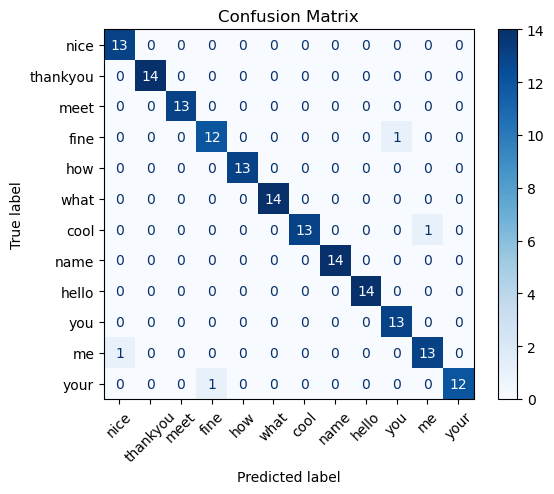

In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(ytrue, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_glosses)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [102]:
from sklearn.metrics import classification_report

print(classification_report(ytrue, ypred, target_names=selected_glosses))

              precision    recall  f1-score   support

        nice       0.93      1.00      0.96        13
    thankyou       1.00      1.00      1.00        14
        meet       1.00      1.00      1.00        13
        fine       0.92      0.92      0.92        13
         how       1.00      1.00      1.00        13
        what       1.00      1.00      1.00        14
        cool       1.00      0.93      0.96        14
        name       1.00      1.00      1.00        14
       hello       1.00      1.00      1.00        14
         you       0.93      1.00      0.96        13
          me       0.93      0.93      0.93        14
        your       1.00      0.92      0.96        13

    accuracy                           0.98       162
   macro avg       0.98      0.98      0.98       162
weighted avg       0.98      0.98      0.98       162

